<a href="https://colab.research.google.com/github/zainnabtarrek/Machine-learning-algorithms-from-scratch/blob/main/Decision_Tree_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree algorithm from scratch to solve a classification problem.(using the entropy method)

## Import Important Libraries

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

## Read the data

In [ ]:
url = "https://raw.githubusercontent.com/zainnabtarrek/tennis/main/PlayTennis.csv"
tennis_data = pd.read_csv(url)
tennis_data

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


## Data Exploring

In [ ]:
tennis_data.describe()

,Outlook,Temperature,Humidity,Wind,Play Tennis
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


In [ ]:
tennis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Wind         14 non-null     object
 4   Play Tennis  14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


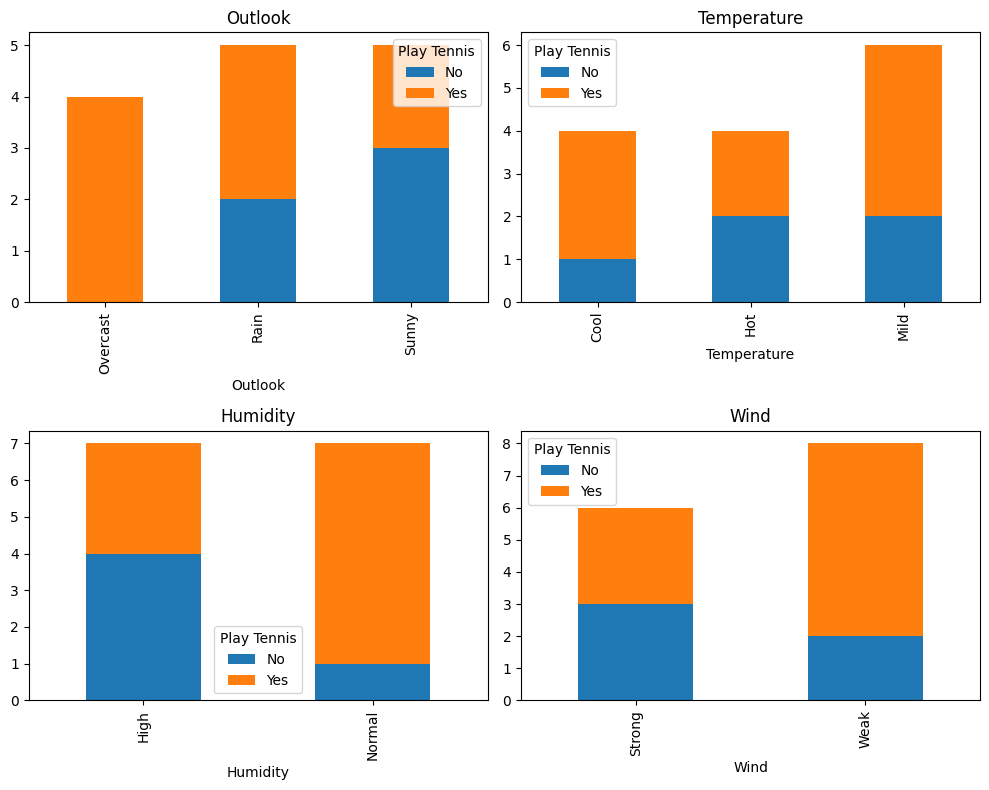

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

tennis_data.groupby(['Outlook', 'Play Tennis']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Outlook')

tennis_data.groupby(['Temperature', 'Play Tennis']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Temperature')

tennis_data.groupby(['Humidity', 'Play Tennis']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Humidity')

tennis_data.groupby(['Wind', 'Play Tennis']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Wind')

plt.tight_layout()
plt.show()

In [ ]:
dic_paly = {"No":0,"Yes":1}
dic_Wind = {"Weak":0,"Strong":1}
dic_Humidity = {"Normal":0,"High":1}

tennis_data['Play Tennis'] = tennis_data['Play Tennis'].map(dic_paly)
tennis_data['Wind'] = tennis_data['Wind'].map(dic_Wind)
tennis_data['Humidity'] = tennis_data['Humidity'].map(dic_Humidity)


tennis_data

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,1,0,0
1,Sunny,Hot,1,1,0
2,Overcast,Hot,1,0,1
3,Rain,Mild,1,0,1
4,Rain,Cool,0,0,1
5,Rain,Cool,0,1,0
6,Overcast,Cool,0,1,1
7,Sunny,Mild,1,0,0
8,Sunny,Cool,0,0,1
9,Rain,Mild,0,0,1


In [ ]:
tennis_data = tennis_data.join(pd.get_dummies(tennis_data.Outlook)).drop(['Outlook'],axis=1)
tennis_data = tennis_data.join(pd.get_dummies(tennis_data.Temperature)).drop(['Temperature'],axis=1)

tennis_data


,Humidity,Wind,Play Tennis,Overcast,Rain,Sunny,Cool,Hot,Mild
0,1,0,0,False,False,True,False,True,False
1,1,1,0,False,False,True,False,True,False
2,1,0,1,True,False,False,False,True,False
3,1,0,1,False,True,False,False,False,True
4,0,0,1,False,True,False,True,False,False
5,0,1,0,False,True,False,True,False,False
6,0,1,1,True,False,False,True,False,False
7,1,0,0,False,False,True,False,False,True
8,0,0,1,False,False,True,True,False,False
9,0,0,1,False,True,False,False,False,True


## Build The Model

In [ ]:
from collections import Counter
from graphviz import Digraph


class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right =right
        self.value = value

    def _is_leaf_node(self):
        return self.value is not None

class Decision_tree:
    def __init__(self, min_samples_split=2, max_depth=100,n_features=None,solve_overfitting=False):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.solve_overfitting = solve_overfitting

    def fit(self,X,y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X,y)

    def _grow_tree(self,X,y,depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        if self.solve_overfitting:
            feat_idxs = np.random.choice(n_features,self.n_features,replace=False)
        else:
            feat_idxs = np.array(range(n_features))

        best_feature, best_threshold = self._best_split(X,y,feat_idxs)

        left_indxs, right_indxs = self._split(X[:,best_feature],best_threshold)
        left = self._grow_tree(X[left_indxs,:],y[left_indxs],depth+1)
        right = self._grow_tree(X[right_indxs,:],y[right_indxs],depth+1)
        return Node(best_feature,best_threshold,left,right)

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] if len(counter)>0 else None
        return value

    def _best_split(self,X,y,feat_indxs):
        best_gain = -1
        split_idx, split_threshold = None, None


        for feat_indx in feat_indxs:

            X_column = X[:,feat_indx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y,X_column,thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_indx
                    split_threshold = thr
        return split_idx, split_threshold

    def _entropy(self,y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return - np.sum([p *np.log(p) for p in ps if p>0])

    def _avg_entropy(self, y, X_column, threshold,left_indx, right_indx ):
        n = len(y)
        n_l, n_r = len(left_indx), len(right_indx)

        e_l, e_r = self._entropy(y[left_indx]), self._entropy(y[right_indx])

        children_entropy = ((n_l/n) * e_l) + ((n_r/n) * e_r)

        return children_entropy

    def _information_gain(self,y,X_column,threshold):
        parent_entropy = self._entropy(y)
        left_indx, right_indx = self._split(X_column,threshold)
        if (len(left_indx) == 0 or len(right_indx) ==0):
            return 0
        info_gain = parent_entropy - self._avg_entropy(y, X_column,threshold, left_indx, right_indx)

        return info_gain

    def _split(self,X_column,threshold):
        left_indx = np.argwhere(X_column <= threshold).flatten()
        right_indx = np.argwhere(X_column > threshold).flatten()
        return left_indx, right_indx

    def predict(self,X):
        return np.array([self._traverse_tree(x,self.root) for x in X])

    def _traverse_tree(self,x,node):
        if node._is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x,node.left)

        return self._traverse_tree(x,node.right)

    def to_dot(self,feature_names):
        dot = Digraph()

        def add_nodes_edges(dot, node):
            if node._is_leaf_node():
              if (str(node.value) == "0"):
                leaf = "Not Play Tennis"
              elif(str(node.value) == "1"):
                leaf = "Play Tennis"
              dot.node(str(id(node)), label=leaf)
              return

            dot.node(str(id(node)), label= feature_names[node.feature])

            if node.left:
                add_nodes_edges(dot, node.left)
                dot.edge(str(id(node)), str(id(node.left)), label="True")

            if node.right:
                add_nodes_edges(dot, node.right)
                dot.edge(str(id(node)), str(id(node.right)), label="False")

        if self.root:
            add_nodes_edges(dot, self.root)

        return dot

In [ ]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

## Test The Model

In [ ]:
X = tennis_data.drop(["Play Tennis"],axis=1)
y = tennis_data["Play Tennis"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [ ]:
clf = Decision_tree(max_depth=3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test, predictions)
print(f"The Accurasy= {acc *100}%")

The Accurasy= 100.0%
